# Mixture Density Networks with Edward, Keras and TensorFlow

This notebook explains how to implement Mixture Density Networks (MDN) with Edward, Keras and TensorFlow.
Keep in mind is that if you want to use Keras and TensorFlow, like we do in this notebook, you need to set the backend of Keras to TensorFlow, [here](http://keras.io/backend/) it is explained how to do that.

In you are not familiar with MDNs have a look at the [following blog post](http://cbonnett.github.io/MDN.html) or at orginal [paper](http://research.microsoft.com/en-us/um/people/cmbishop/downloads/Bishop-NCRG-94-004.pdf) by Bishop.

Edward implements many probability distribution functions that are TensorFlow compatible, this makes it attractive to use Edward for MDNs.  

Here are all the distributions that are currently implemented in Edward, there are more to come:

1. [Bernoulli](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L49)
2. [Beta](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L58)
3. [Binomial](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L68)
4. [Chi Squared](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L79)
5. [Dirichlet](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L89)
6. [Exponential](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L109)
7. [Gamma](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L118)
8. [Geometric](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L129)
9. [Inverse Gamma](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L138)
10. [log Normal](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L155)
11. [Multinomial](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L165)
12. [Multivariate Normal](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L194)
13. [Negative Binomial](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L283)
14. [Normal](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L294)
15. [Poisson](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L310)
16. [Student-t](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L319)
17. [Truncated Normal](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L333)
18. [Uniform](https://github.com/blei-lab/edward/blob/master/edward/stats/distributions.py#L352)

Let's start with the necessary imports.

In [11]:
# imports
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import edward as ed
import numpy as np
import tensorflow as tf

from edward.stats import norm #  Normal distribution from Edward. 
from keras import backend as K
from keras.layers import Dense
from sklearn.cross_validation import train_test_split

We will need some functions to plot the results later on, these are defined in the next code block. 

In [12]:
from scipy.stats import norm as normal
def plot_normal_mix(pis, mus, sigmas, ax, label='', comp=True):
    """
    Plots the mixture of Normal models to axis=ax
    comp=True plots all components of mixture model
    """
    x = np.linspace(-10.5, 10.5, 250)
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = normal.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, label='Normal ' + str(i))
    ax.plot(x, final, label='Mixture of Normals ' + label)
    ax.legend(fontsize=13)
    
def sample_from_mixture(x, pred_weights, pred_means, pred_std, amount):
    """
    Draws samples from mixture model. 
    Returns 2 d array with input X and sample from prediction of Mixture Model
    """
    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j,(weights, means, std_devs) in enumerate(zip(pred_weights, pred_means, pred_std)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j,1]= normal.rvs(means[index], std_devs[index], size=1)
        samples[j,0]= x[j]
        if j == amount -1:
            break
    return samples

## Making some toy-data to play with.

This is the same toy-data problem set as used in the [blog post](http://blog.otoro.net/2015/11/24/mixture-density-networks-with-tensorflow/) by Otoro where he explains MDNs. This is an inverse problem as you can see, for every ```X``` there are multiple ```y``` solutions.

Size of features in training data: (4000, 1)
Size of output in training data: (4000, 1)
Size of features in test data: (36000, 1)
Size of output in test data: (36000, 1)


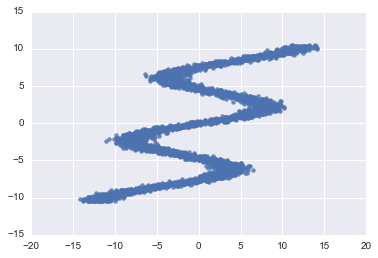

In [13]:
def build_toy_dataset(nsample=40000):
    y_data = np.float32(np.random.uniform(-10.5, 10.5, (1, nsample))).T
    r_data = np.float32(np.random.normal(size=(nsample, 1))) # random noise
    x_data = np.float32(np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0)
    return train_test_split(x_data, y_data, random_state=42, train_size=0.1)

X_train, X_test, y_train, y_test = build_toy_dataset()
print("Size of features in training data: {:s}".format(X_train.shape))
print("Size of output in training data: {:s}".format(y_train.shape))
print("Size of features in test data: {:s}".format(X_test.shape))
print("Size of output in test data: {:s}".format(y_test.shape))

sns.regplot(X_train, y_train, fit_reg=False)

### Building a MDN using Edward, Keras and TF

We will define a class that can be used to construct MDNs. In this notebook we will be using a mixture of Normal Distributions. The advantage of defining a class is that we can easily reuse this to build other MDNs with different amount of mixture components. Furthermore, this makes it play nicely with Edward.

In [14]:
class MixtureDensityNetwork:
    """
    Mixture density network for outputs y on inputs x.
    p((x,y), (z,theta))
    = sum_{k=1}^K pi_k(x; theta) Normal(y; mu_k(x; theta), sigma_k(x; theta))
    where pi, mu, sigma are the output of a neural network taking x
    as input and with parameters theta. There are no latent variables
    z, which are hidden variables we aim to be Bayesian about.
    """
    def __init__(self, K):
        self.K = K # here K is the amount of Mixtures 

    def mapping(self, X):
        """pi, mu, sigma = NN(x; theta)"""
        hidden1 = Dense(15, activation='relu')(X)  # fully-connected layer with 15 hidden units
        hidden2 = Dense(15, activation='relu')(hidden1) 
        self.mus = Dense(self.K)(hidden2) # the means 
        self.sigmas = Dense(self.K, activation=K.exp)(hidden2) # the variance
        self.pi = Dense(self.K, activation=K.softmax)(hidden2) # the mixture components

    def log_prob(self, xs, zs=None):
        """log p((xs,ys), (z,theta)) = sum_{n=1}^N log p((xs[n,:],ys[n]), theta)"""
        # Note there are no parameters we're being Bayesian about. The
        # parameters are baked into how we specify the neural networks.
        X, y = xs
        self.mapping(X)
        result = tf.exp(norm.logpdf(y, self.mus, self.sigmas))
        result = tf.mul(result, self.pi)
        result = tf.reduce_sum(result, 1)
        result = tf.log(result)
        return tf.reduce_sum(result)

We can set a seed in Edward so we can reproduce all the random components. The following line:

```ed.set_seed(42)```

sets the seed in Numpy and TensorFlow under the [hood](https://github.com/blei-lab/edward/blob/master/edward/util.py#L191). We use the class we defined above to initiate the MDN with 20 mixtures, this now can be used as an Edward model.

In [15]:
ed.set_seed(42)
model = MixtureDensityNetwork(20)

In the following code cell we define the TensorFlow placeholders that are then used to define the Edward data model.
The following line passes the ```model``` and ```data``` to ```MAP``` from Edward which is then used to initialise the TensorFlow variables. 

```inference = ed.MAP(model, data)``` 

MAP is a Bayesian concept and stands for Maximum A Posteriori, it tries to find the set of parameters which maximizes the posterior distribution. In the example here we don't have a prior, in a Bayesian context this means we have a flat prior. For a flat prior MAP is equivalent to Maximum Likelihood Estimation. Edward is designed to be Bayesian about its statistical inference. The cool thing about MDN's with Edward is that we could easily include priors! 

In [16]:
X = tf.placeholder(tf.float32, shape=(None, 1))
y = tf.placeholder(tf.float32, shape=(None, 1))
data = ed.Data([X, y]) # Make Edward Data model

inference = ed.MAP(model, data) # Make the inference model
sess = tf.Session() # Start TF session 
K.set_session(sess) # Pass session info to Keras
inference.initialize(sess=sess) # Initialize all TF variables using the Edward interface 

Having done that we can train the MDN in TensorFlow just like we normally would, and we can get out the predictions we are interested in from ```model```, in this case: 

* ```model.pi``` the mixture components, 
* ```model.mus``` the means,
* ```model.sigmas``` the standard  deviations.   

This is done in the last line of the code cell :
```
pred_weights, pred_means, pred_std = sess.run([model.pi, model.mus, model.sigmas], 
                                              feed_dict={X: X_test})
```

The default minimisation technique used is ADAM with a decaying scale factor.
This can be seen [here](https://github.com/blei-lab/edward/blob/master/edward/inferences.py#L94) in the code base of Edward. Having a decaying scale factor is not the standard way of using ADAM, this is inspired by the Automatic Differentiation Variational Inference [(ADVI)](http://arxiv.org/abs/1603.00788) work where it was used in the RMSPROP minimizer.      

The loss that is minimised in the ```MAP``` model from Edward is the negative log-likelihood, this calculation uses the  ```log_prob``` method in the ```MixtureDensityNetwork``` class we defined above. 
The ```build_loss``` method in the ```MAP``` class can be found [here](https://github.com/blei-lab/edward/blob/master/edward/inferences.py#L396). 

However the method ```inference.loss``` used below, returns the log-likelihood, so we expect this quantity to be maximized.

In [17]:
NEPOCH = 1000
train_loss = np.zeros(NEPOCH)
test_loss = np.zeros(NEPOCH)
for i in range(NEPOCH):
    _, train_loss[i] = sess.run([inference.train, inference.loss],
                                feed_dict={X: X_train, y: y_train})
    test_loss[i] = sess.run(inference.loss, feed_dict={X: X_test, y: y_test})
    
pred_weights, pred_means, pred_std = sess.run([model.pi, model.mus, model.sigmas], 
                                              feed_dict={X: X_test})

We can plot the log-likelihood of the training and test sample as function of training epoch.
Keep in mind that ```inference.loss``` returns the total log-likelihood, so not the loss per data point, so in the plotting routine we divide by the size of the train and test data respectively. 
We see that it converges after 400 training steps.

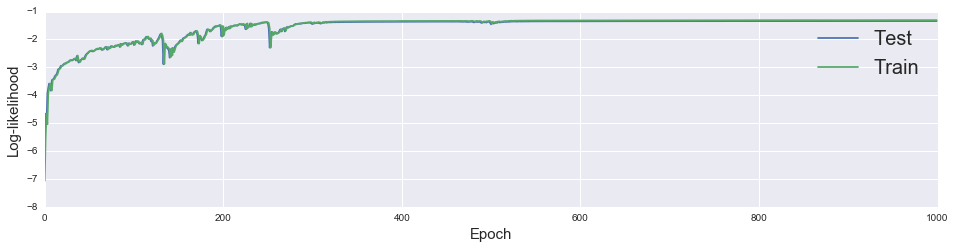

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(NEPOCH), test_loss/len(X_test), label='Test')
plt.plot(np.arange(NEPOCH), train_loss/len(X_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)

Next we can have a look at how some individual examples perform. Keep in mind this is an inverse problem
so we can't get the answer correct, we can hope that the truth lies in area where the model has high probability.
In the next plot the truth is the vertical grey line while the blue line is the prediction of the mixture density network. As you can see, we didn't do too bad.

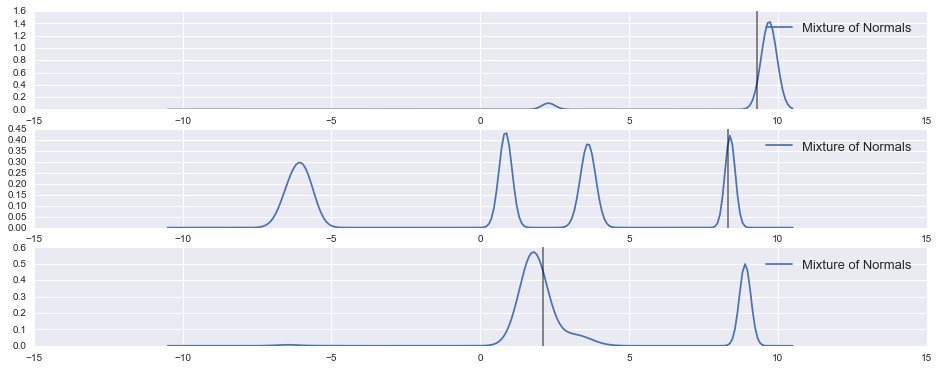

In [19]:
obj = [0, 4, 6]
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(16, 6))

plot_normal_mix(pred_weights[obj][0], pred_means[obj][0], pred_std[obj][0], axes[0], comp=False)
axes[0].axvline(x=y_test[obj][0], color='black', alpha=0.5)

plot_normal_mix(pred_weights[obj][2], pred_means[obj][2], pred_std[obj][2], axes[1], comp=False)
axes[1].axvline(x=y_test[obj][2], color='black', alpha=0.5)

plot_normal_mix(pred_weights[obj][1], pred_means[obj][1], pred_std[obj][1], axes[2], comp=False)
axes[2].axvline(x=y_test[obj][1], color='black', alpha=0.5)

We can check the ensemble by drawing samples of the prediction and plotting the density of those. 
Seems the MDN learned what it needed too.

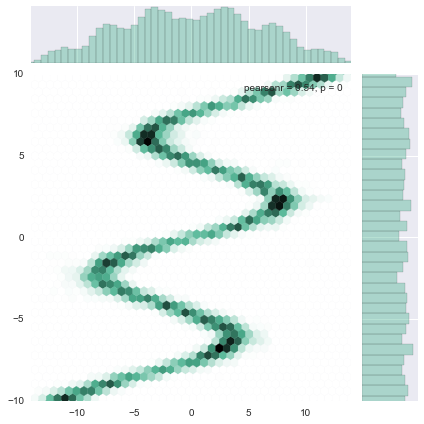

In [20]:
a = sample_from_mixture(X_test, pred_weights, pred_means, pred_std, amount=len(X_test))
sns.jointplot(a[:,0], a[:,1], kind="hex", color="#4CB391", ylim=(-10,10), xlim=(-14,14))